# 4-Oscar Prediction with AutoML
After out dataframe has been assemlbed (see scraping and table_assembling) notebooks we have the data we need to make predictions on the Best Picture winner. [AutoML](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html) represents a quick, but powerful route though the Machine Learning process. H2O's AutoML runs many models through the dataset and using cross-validation, picks the best one. For my purposes I use it to confirm/compare to the Preferential Balloting Random Forest model I created.
If you are gunning to win your office's Oscar pool, scroll down to see the results.

In [1]:
import pandas as pd
import numpy as np
import h2o


# Machine Learning - Using h2o Auto ML

In [2]:
full_table = pd.read_csv('./data/processed_results/osc_df')

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from C:\Users\aczaplak.MPD1\AppData\Local\Programs\Python\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ACZAPL~1.MPD\AppData\Local\Temp\tmpf1dg70wd
  JVM stdout: C:\Users\ACZAPL~1.MPD\AppData\Local\Temp\tmpf1dg70wd\h2o_aczaplak_started_from_python.out
  JVM stderr: C:\Users\ACZAPL~1.MPD\AppData\Local\Temp\tmpf1dg70wd\h2o_aczaplak_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_aczaplak_evj1hv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.752 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


First Year of Existance. This data will be used below
- golden_globes 1943
- pga 1989
- bafta 1960
- dga 1948
- sag 1995
- cannes 1970

In [6]:
# I pick a min_year where the awards shows will be relevant
min_year = 1995

# H2O's Auto ML

In [7]:
# Auto ML uses Cross Validation, so we do not specifiy a validation set
train = full_table.loc[((full_table['year'] < 2022) & (full_table['year'] >= min_year))]

print('training set contains:', train.shape[0], 'movies')

training set contains: 189 movies


In [8]:
train = train.drop('Unnamed: 0', axis=1)
train.columns

Index(['year', 'film', 'wiki', 'winner', 'nominations', 'Oscar_win',
       'nom_gg_drama', 'winner_gg_drama', 'nom_gg_comedy', 'winner_gg_comedy',
       'nom_pga', 'winner_pga', 'nom_bafta', 'winner_bafta', 'nom_dga',
       'winner_dga', 'nom_sag', 'winner_sag'],
      dtype='object')

In [9]:
print(type(train))

<class 'pandas.core.frame.DataFrame'>


In [9]:
from h2o.automl import H2OAutoML, get_leaderboard

# Import a sample binary outcome train/test set into H2O
train1 = h2o.H2OFrame(train)
# Identify predictors and response
predictors = ['nom_gg_drama', 'winner_gg_drama', 'nom_gg_comedy', 'winner_gg_comedy',
       'nom_pga', 'winner_pga', 'nom_bafta', 'winner_bafta', 'nom_dga', 'winner_dga',
        'nom_sag', 'winner_sag','nominations']

x = predictors
y = 'Oscar_win'

# For binary classification, response should be a factor
train1[y] = train1[y].asfactor()

# Run AutoML for 100 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=100, seed=1
                , keep_cross_validation_predictions= True,
                exclude_algos=['StackedEnsemble'],
               balance_classes=True,
               sort_metric='aucpr')

aml.train(x=x, y=y, training_frame=train1)

# AutoML Leaderboard
lb = aml.leaderboard

# Optionally edd extra model information to the leaderboard
lb = get_leaderboard(aml, extra_columns='ALL')

# Print all rows (instead of default 10 rows)
lb.head(rows=lb.nrows)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
13:21:08.788: AutoML: XGBoost is not available; skipping it.


13:21:10.848: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 189.0.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
DeepLearning_grid_2_AutoML_1_20230608_132108_model_6,0.706995,0.897959,0.433621,0.162267,0.309404,0.0957311,9232,0.096038,DeepLearning
DeepLearning_grid_3_AutoML_1_20230608_132108_model_14,0.688767,0.883984,0.359282,0.162267,0.297517,0.0885164,17045,0.13667,DeepLearning
DeepLearning_grid_1_AutoML_1_20230608_132108_model_9,0.688293,0.896185,0.32923,0.186335,0.311839,0.0972434,8880,0.063583,DeepLearning
DeepLearning_grid_2_AutoML_1_20230608_132108_model_13,0.684937,0.914596,0.304029,0.13354,0.295338,0.0872247,10378,0.064971,DeepLearning
DeepLearning_grid_3_AutoML_1_20230608_132108_model_6,0.684845,0.879769,0.390963,0.259317,0.333334,0.111111,11748,0.089005,DeepLearning
DeepLearning_grid_2_AutoML_1_20230608_132108_model_14,0.679179,0.879326,0.460222,0.154503,0.329071,0.108287,10616,0.05466,DeepLearning
DeepLearning_grid_3_AutoML_1_20230608_132108_model_15,0.678074,0.893744,0.423651,0.159938,0.319851,0.102305,10343,0.049036,DeepLearning
DeepLearning_grid_1_AutoML_1_20230608_132108_model_11,0.666139,0.876442,0.459232,0.188665,0.302206,0.0913285,6637,0.048662,DeepLearning
DeepLearning_grid_1_AutoML_1_20230608_132108_model_14,0.666121,0.869122,0.484441,0.227484,0.332825,0.110772,7916,0.060778,DeepLearning
DeepLearning_grid_2_AutoML_1_20230608_132108_model_8,0.665263,0.873558,0.450321,0.195652,0.336239,0.113057,41020,0.082039,DeepLearning


In [10]:
top_model_new = aml.leader
top_model_new

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_2_AutoML_1_20230608_132108_model_6


Status of Neuron Layers: predicting Oscar_win, 2-class classification, bernoulli distribution, CrossEntropy loss, 11 702 weights/biases, 144,4 KB, 486 000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight           weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  --------------------  -------------------  --------------------  ------------------
    1        13       Input             15.0
    2        100      RectifierDropout  50.0       0.0   0.0   0.0029879750995874367  0.0030784253031015396  0.0         -0.05838601863210967  0.2881765365600586   -0.24603624675698055  0.2103530764579773
    3        100      RectifierDropout  50.0       0.0   0.0   0.03179481515949883    0.10325378179550171    0.0         -0.01921535937315166  0.16676926612854004  0.06702001045899145   0.2651761770248413
    4        2        Softmax                      0.0   0.0   0.00963188176159747    0.01723741739988327    0.0         0.02043896063696593   0.7717950344085693   0.10911306491271944   0.7875525951385498

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.017255181887952033
RMSE: 0.131358980994647
LogLoss: 0.06780287950030127
Mean Per-Class Error: 0.009316770186335404
AUC: 0.9979042030255687
AUCPR: 0.9977534145500758
Gini: 0.9958084060511374

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48788822173285695
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      158  3    0.0186   (3.0/161.0)
1      0    163  0        (0.0/163.0)
Total  158  166  0.0093   (3.0/324.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487888     0.990881  28
max f2                       0.487888     0.996333  28
max f0point5                 0.487888     0.98549   28
max accuracy                 0.487888     0.990741  28
max precision                0.999881     1         0
max recall                   0.487888     1         28
max specificity              0.999881     1         0
max absolute_mcc             0.487888     0.981647  28
max min_per_class_accuracy   0.487888     0.981366  28
max mean_per_class_accuracy  0.487888     0.990683  28
max tns                      0.999881     161       0
max fns                      0.999881     157       0
max fps                      6.42961e-23  161       145
max tps                      0.487888     163       28
max tnr                      0.999881     1         0
max fnr                      0.999881     0.96319   0
max fpr                      6.42961e-23  1         145
max tpr                      0.487888     1         28

Gains/Lift Table: Avg response rate: 50,31 %, avg score: 47,43 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0185185                   0.999881           1.98773  1.98773            1                0.999881     1                           0.999881            0.0368098       0.0368098                  98.773   98.773             0.0368098
2        0.037037                    0.999459           1.98773  1.98773            1                0.999459    

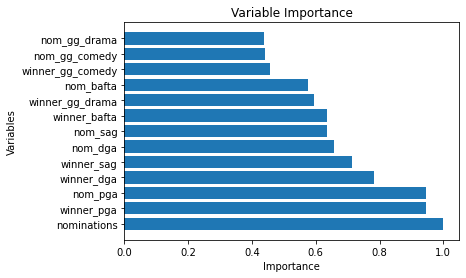

In [11]:
import matplotlib.pyplot as plt
# Get the variable importance table
var_importance = aml.leader.varimp()

# Extract variable names and importances
variables = [item[0] for item in var_importance]
importances = [item[1] for item in var_importance]

# Plot the variable importance
plt.barh(variables, importances)
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Variable Importance")
plt.show()


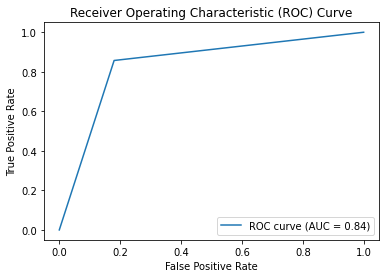

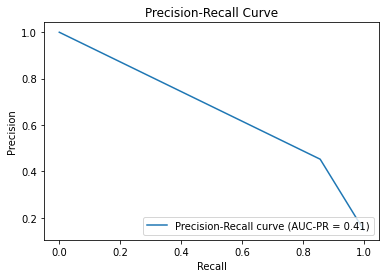

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# Get the cross-validated predictions and true labels
preds = aml.leader.cross_validation_holdout_predictions().as_data_frame()["predict"].values
true_labels = train[y].values

# Calculate the ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

# Calculate the precision-recall curve and AUC-PR
precision, recall, _ = precision_recall_curve(true_labels, preds)
pr_auc = average_precision_score(true_labels, preds)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall curve (AUC-PR = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
lb.as_data_frame().to_csv('./basic_model/leaderboard.csv')

## Predict the winner

In [14]:
# Predict on 2019's films
test = full_table.loc[(full_table['year'] == 2010)]

# Import a binary outcome train/test set into H2O
test = h2o.H2OFrame(test)

# For binary classification, response should be a factor
test[y] = test[y].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
preds = top_model_new.predict(test)

preds

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.00232637,0.997674
0,0.998996,0.00100417
0,0.999622,0.000378384
0,0.999992,7.69185e-06
0,1,8.11958e-22
0,1,4.70432e-16
1,0.512112,0.487888
0,1,1.31189e-17
0,1,4.30652e-12
0,1,1.27444e-15


In [16]:
test['pred'] = preds['predict']
test['probA'] = preds['p1']
test_pd = test.as_data_frame(use_pandas=True)

In [17]:
final_rankings = test_pd[['film','probA']].sort_values('probA', ascending = False)
final_rankings['%_confidence'] = final_rankings['probA']/final_rankings['probA'].sum() * 100
final_rankings

,film,probA,%_confidence
0,The King's Speech,9.976736e-01,6.709521e+01
6,The Social Network,4.878882e-01,3.281129e+01
1,Black Swan,1.004170e-03,6.753209e-02
2,The Fighter,3.783844e-04,2.544698e-02
3,Inception,7.691853e-06,5.172899e-04
8,True Grit,4.306520e-12,2.896206e-10
9,Winter's Bone,1.274438e-15,8.570805e-14
5,127 Hours,4.704322e-16,3.163735e-14
7,Toy Story 3,1.311894e-17,8.822705e-16
4,The Kids Are All Right,8.119576e-22,5.460550e-20


# And the Oscar goes to...

In [18]:
bp_winner = np.array(final_rankings.reset_index())[0][1].split('(')[0].strip()
print(f'And the Oscar goes to...\n🎉🏆{bp_winner}🏆🎉')

And the Oscar goes to...
🎉🏆The King's Speech🏆🎉


In [30]:
# Predict on 2019's films
test = full_table.loc[(full_table['year'] == 2000)]

# Import a binary outcome train/test set into H2O
test = h2o.H2OFrame(test)

# For binary classification, response should be a factor
test[y] = test[y].asfactor()
preds = top_model_new.predict(test)
test['pred'] = preds['predict']
test['probA'] = preds['p1']
test_pd = test.as_data_frame(use_pandas=True)
final_rankings = test_pd[['film','probA']].sort_values('probA', ascending = False)
final_rankings['%_confidence'] = final_rankings['probA']/final_rankings['probA'].sum() * 100
final_rankings

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,film,probA,%_confidence
0,Gladiator,8.634851e-01,9.999574e+01
2,"Crouching Tiger, Hidden Dragon",1.784432e-05,2.066459e-03
4,Traffic,9.837828e-06,1.139268e-03
3,Erin Brockovich,9.108608e-06,1.054821e-03
1,Chocolat,8.480055e-23,9.820313e-21
